<a href="https://colab.research.google.com/github/ManishMallik/MachineLearning/blob/main/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WORKING CELL

In [8]:
import re
import numpy as np
import zipfile
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# preprocess individual tweets
def preprocess_tweet(tweet):
    try:
        # decode the bytes to string
        tweet = tweet.decode('utf-8')

        # '|' is the delimeter, so split each tweet using that delimeter
        elements = tweet.split('|')

        # Check if there are at least three elements
        # if len(elements) >= 3:
        # Take the third element (index 2) as the tweet content
        processed_tweet = elements[2]

        # convert every word to lowercase
        processed_tweet = processed_tweet.lower()

        # remove any words that start with @
        processed_tweet = re.sub(r'@\S+', '', processed_tweet)

        # remove the hashtag symbols
        processed_tweet = re.sub(r'#', '', processed_tweet)

        # remove the URL links
        processed_tweet = re.sub(r'http\S+', '', processed_tweet)

        return processed_tweet

    except Exception as e:
        print(f"Error processing tweet: {e}")

    # return an empty string if conditions are not met
    return ""

# preprocessing a text file of tweets
def preprocess(zip_file_url, text_file_path):

    # get the zip folder
    response = requests.get(zip_file_url)

    # open the zip folder and access the text file we want to access
    with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
        with zip_ref.open(text_file_path) as file:
            data = file.readlines()

    # preprocess each tweet, and add them to the list of tweets
    tweets = []
    for tweet in data:
        tweets.append(preprocess_tweet(tweet))

    # return the preprocessed tweets
    print(tweets)
    return tweets

# Class for the K-Means Clustering algorithm
class KMeansClustering:

    # initiate this with a k value, which would represent the number of clusters
    def __init__(self, k):
        self.k = k

    # Jaccard distance is used to calculate the similarity between two tweets based on their set of words
    def jaccard_distance(self, set1, set2):

        # find how many unique words, letters, and/or numbers both the 1st tweet and 2nd tweet share
        inter_cardinality = len(set1.intersection(set2))

        # find how many unique words, letters, and/or numbers in total when doing union between 1st and 2nd tweets
        union_cardinality = len(set1.union(set2))

        # if the size of the union set is 0, return 0
        if union_cardinality == 0:
            return 0

        # formula for calculating the Jaccard similarity distance
        return 1 - (inter_cardinality / union_cardinality)

    # assigning all tweets to the clusters
    def assign_to_cluster(self, data, clusters, centroids):

        # compare every tweet to the centroids
        for tweet in data:

            # initializing the variables
            min_distance = -1
            closest_centroid = 0
            centroid_num = 0

            # for each tweet, calculate the jaccard distance between all k centroids
            for centroid in centroids:
                distance = self.jaccard_distance(tweet, centroid)

                # update the minimum distance and centroid that the tweet should be assigned to
                if min_distance == -1 or distance < min_distance:
                    min_distance = distance
                    closest_centroid = centroid_num
                centroid_num += 1

            # based on the closest centroid for a tweet, add that tweet to the
            assigned_cluster = closest_centroid
            clusters[assigned_cluster].append(tweet)

        # return the clusters
        return clusters

    # recomputing the centroids
    def recompute_centroids(self, clusters):

        # have an empty array of new centroids initialized. there will be k updated centroids added
        new_centroids = []

        # update the centroid for each cluster
        for i in range(self.k):

            # initializing min_distance and an empty set as new centroid for each cluster
            clus = clusters[i]
            min_distance = -1
            best_centroid = set()

            # for each tweet in a cluster, start with a distance of 0 and assume it as a possible centroid choice
            for tweet in clus:
                distance = 0
                centroid = tweet

                # calculate the total jaccard distance between that tweet and the other tweets
                for other_tweet in clus:
                    distance += self.jaccard_distance(tweet, other_tweet)

                # update the minimum jaccard distance and assume that tweet is the best choice for a centroid
                if min_distance == -1 or distance < min_distance:
                    min_distance = distance
                    best_centroid = centroid

            # store the updated centroid for each cluster in an array
            new_centroids.append(best_centroid)

        # return the updated centroids
        return new_centroids

    # The K-means clustering algorithm
    def k_means_clustering(self, data, max_iterations=1000):

        # randomly choose k index numbers
        randomly_chosen = np.random.choice(len(data), self.k, replace=False)
        # print(randomly_chosen)
        # based on those numbers, get those tweets/sets of unordered words and label them as centroids
        centroids = []
        for i in randomly_chosen:
          centroids.append(data[i])
        # print(centroids)
        # print(len(centroids))

        # initializing prev_centroids to keep track of the previous centroids after each iteration
        # initializing the number of iterations
        prev_centroids = []
        iterations = 0

        # repeat the following steps until one of the following occur:
        # 1. convergence (the previous centroids and current centroids are the same, this should most likely occur)
        # 2. reaching the number of max iterations (assuming it does not get to convergence)
        while prev_centroids != centroids and iterations < max_iterations:

            # start each iteration with k empty clusters
            clusters = []
            for i in range(0, self.k):
              clusters.append([])

            # Part 1: assign all points to the closest centroid
            clusters = self.assign_to_cluster(data, clusters, centroids)

            # Part 2: recompute the centroid of each cluster
            new_centroids = self.recompute_centroids(clusters)

            # store the current centroids as previous centroids, and assign the new centroids as the current centroids
            prev_centroids = centroids
            centroids = new_centroids

            # update the number of iterations that have occurred so far
            iterations += 1

        # print(iterations)
        # return the final centroids and their clusters
        return clusters, centroids

    # calculate the SSE
    def sse(self, clusters, centroids):
        # initialize SSE to 0
        sse = 0

        # start the process
        for i in range(len(clusters)):

            # for each centroid in a cluster, calculate the distance between it and all of the other points in the same cluster
            centroid = centroids[i]

            # add the squared jaccard similarity distance between each tweet and the centroid
            # Note: the centroid is also included in the cluster, but the similarity distance will be 0 regardless
            for tweet in clusters[i]:
                # if pow(self.jaccard_distance(tweet, centroid), 2) == 0:
                #   print(f"Adding {pow(self.jaccard_distance(tweet, centroid), 2)}")
                sse += pow(self.jaccard_distance(tweet, centroid), 2)

        # return the SSE
        return sse

# main method
if __name__ == '__main__':

    # get the zip file and text file of our choice from the database
    zip_file_url = "https://archive.ics.uci.edu/static/public/438/health+news+in+twitter.zip"
    text_file_path_in_zip = "Health-Tweets/usnewshealth.txt"

    # preprocess the tweets
    tweets = preprocess(zip_file_url, text_file_path_in_zip)

    # for this assignment, a tweet can be considered as an unordered set of words
    # for each tweet, convert it into a set of unique words, letters, and/or numbers. Punctuation is removed
    tweet_sets = [set(re.findall(r'\b\w+\b', tweet)) for tweet in tweets]
    print(tweet_sets)

    # use different values of k for the K-means clustering algorithm
    k_values = [5, 10, 25, 50, 75, 100]
    sse_values = []
    for k in k_values:

        # mention the number of clusters
        print(f"{k} Clusters:")

        # perform the algorithm with k clusters
        algorithm = KMeansClustering(k)
        clusters, centroids = algorithm.k_means_clustering(tweet_sets)

        # get the SSE for each cluster and store it
        sse = algorithm.sse(clusters, centroids)
        sse_values.append(sse)

        # print the SSE value
        print(f"Sum of Squared Error (SSE): {sse}")

        # print the size of each cluster
        i = 1
        for cluster in clusters:
            print(f"Cluster {i}: {len(cluster)} tweets")
            i += 1
        print("")


['planning to hire a personal trainer? read these 7 tips first: \n', "rt  any dads out their who struggled w/ depression or anxiety after their kid was born? let's talk! amiller[at]usnews[dot]co…\n", "america's problem with diabetes in one map:   by   \n", "think water &amp; fiber will cure your constipation? unlikely. here's why: \n", 'about to lose it? here, try one of these office-approved relaxation exercises:  stress\n', "should you get your baby's dna decoded?  genetics\n", '3 easy ways to eliminate work stress:  via \n', '7 steps for choosing &amp; keeping the right personal trainer:  by  personaltraining\n', 'getting ready for bikini season? don\'t.  with the "anti-bikini season diet" \n', "there's a reason you're still fat. in fact, 6 of them.  weightloss\n", 'are your allergies just annoying -- or do they require medical attention? how to know: \n', "don't think your digestive system can handle another passover dinner? if you follow  advice, it can: \n", 'how about some mood-

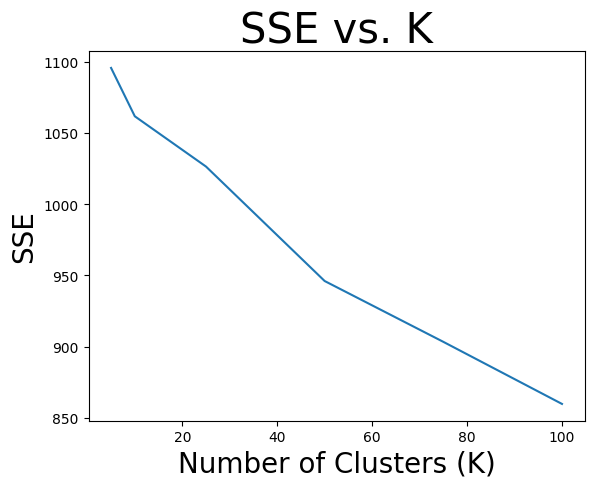

In [9]:
    plt.plot(k_values, sse_values)
    plt.title('SSE vs. K', size = 30 )
    plt.xlabel('Number of Clusters (K)', size = 20)
    plt.ylabel('SSE', size=20)
    plt.show()

In [ ]:
import re
from collections import Counter
import numpy as np

def preprocess():
    url = "usnewshealth.txt"
    file1 = open(url, 'r')
    #data = pd.read_csv(url, delimiter="|")
    data = file1.readlines()
    for i in range(0, len(data)):
      tweet = preprocess_tweet(data[i])
      data[i] = tweet
    print(len(data))
    return data

def preprocess_tweet(tweet):
    # Remove tweet id and timestamp
    tweet = tweet.split('|')[2]

    # Convert every word to lowercase
    tweet = tweet.lower()

    # Remove words starting with @
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove hashtag symbols and convert hashtags to lowercase
    tweet = re.sub(r'#', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)

    return tweet

def jaccard_distance(set1, set2):
    intersection = float(len(set1.intersection(set2)))
    union = len(set1.union(set2))
    if(union == 0):
      return 0
    return (1 - (intersection / union))

def k_means_clustering(data, k, max_iterations=1000):
    centroids = np.random.choice(len(data), k, replace=False)
    centroids = [data[i] for i in centroids]
    clusters = []
    print(centroids)
    print(len(centroids))
    prev_centroids = []
    list1 = ['a', 'b', 'c']
    list2 = ['a', 'b', 'c']
    print (list1 == list2)
    iterations = 0
    # for l in range (max_iterations)
    while prev_centroids != centroids:
        iterations += 1
        clusters = []
        for i in range(0, k):
            clusters.append([])
        for point in data:
            # print(f"Point {j}: {point}")
            # j += 1
            minDistance = -1
            centroid_num = 0
            chosen_centroid = 0
            for centroid in centroids:
                distance = jaccard_distance(point, centroid)
                #print(f"Centroid {centroid_num} and its Distance: {distance}")
                if minDistance == -1 or distance < minDistance:
                    minDistance = distance
                    chosen_centroid = centroid_num
                centroid_num += 1
            # similarities = [jaccard_similarity(point, centroid) for centroid in centroids]
            # assigned_cluster = np.argmin(similarities)
            assigned_cluster = chosen_centroid
            # print(similarities)
            #print(assigned_cluster)
            clusters[assigned_cluster].append(point)
        #new_centroids = [set.union(*cluster) if cluster else centroids[i] for i, cluster in enumerate(clusters)]
        new_centroids = []
        for i in range(0, k):
            clus = clusters[i]
            minDistance = -1
            chooseCentroid = set()
            for tweet in clus:
                distance = 0
                centroid = tweet
                for other_tweet in clus:
                    distance += jaccard_distance(tweet, other_tweet)
                if minDistance == -1 or distance < minDistance:
                    minDistance = distance
                    chooseCentroid = centroid
            new_centroids.append(chooseCentroid)
        #print(f"Update centroid: {new_centroids}")
        prev_centroids = centroids
        centroids = new_centroids

        # if prev_centroids == centroids:
        #     break
    print(iterations)
    return clusters, centroids

def calculate_sse(clusters, centroids):
    sse = 0
    for i in range(0, len(clusters)):
        centroid = centroids[i]
        for point in clusters[i]:
            sse += pow(jaccard_distance(point, centroid), 2)  # Jaccard distance is used here
    return sse

# Example usage:

# Assuming 'clusters' and 'centroids' are the result of your K-means clustering

tweets = preprocess()

# Tokenize tweets into sets of words
tweet_sets = [set(re.findall(r'\b\w+\b', tweet)) for tweet in tweets]
#tokenized_tweets = [set(re.sub(r'[^\w\s]', '', tweet).split()) for tweet in tweets]
print(tweet_sets)

# Apply K-means clustering
k = 5  # Number of clusters
clusters, centroids = k_means_clustering(tweet_sets, k)

sse = calculate_sse(clusters, centroids)
print(f"Sum of Squared Error (SSE): {sse}")

# Print the clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {len(cluster)} tweets")
    # for tweet in cluster:
    #     print("-", tweet)


1400
[{'these', 'tips', 'a', 'to', 'read', 'planning', 'first', 'hire', 'trainer', '7', 'personal'}, {'their', 'talk', 'let', 'dads', 'out', 'w', 'co', 'any', 'kid', 'was', 'at', 's', 'born', 'after', 'amiller', 'rt', 'who', 'usnews', 'dot', 'struggled', 'anxiety', 'or', 'depression'}, {'one', 'diabetes', 'with', 'by', 'in', 'map', 's', 'problem', 'america'}, {'constipation', 'cure', 'unlikely', 'water', 'your', 'here', 'why', 'will', 'fiber', 's', 'think', 'amp'}, {'these', 'about', 'lose', 'one', 'to', 'office', 'it', 'here', 'exercises', 'stress', 'of', 'try', 'approved', 'relaxation'}, {'genetics', 'get', 'should', 'your', 'dna', 'baby', 'you', 's', 'decoded'}, {'3', 'to', 'stress', 'easy', 'via', 'eliminate', 'work', 'ways'}, {'for', 'keeping', 'personaltraining', 'steps', 'by', 'right', 'the', 'trainer', 'choosing', '7', 'personal', 'amp'}, {'for', 'don', 'bikini', 't', 'with', 'anti', 'getting', 'diet', 'the', 'season', 'ready'}, {'re', 'a', 'reason', 'there', 'still', 'of', 'we

MODIFIED TO TEST

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re

def preprocess():
    url = "usnewshealth.txt"
    file1 = open(url, 'r')
    #data = pd.read_csv(url, delimiter="|")
    data = file1.readlines()
    for i in range(0, len(data)):
      tweet = preprocess_tweet(data[i])
      data[i] = tweet
    print(data[2])
    return data

def preprocess_tweet(tweet):
    # Remove tweet id and timestamp
    tweet = tweet.split('|')[2]

    # Convert every word to lowercase
    tweet = tweet.lower()

    # Remove words starting with @
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove hashtag symbols and convert hashtags to lowercase
    tweet = re.sub(r'#', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)

    return tweet

if __name__ == '__main__':

    #X_train, y_train, X_test, y_test = preprocess()
    preprocess()
    tweet1 = "586278450392133633|Thu Apr 09 21:24:09 +0000 2015|Planning to hire a personal trainer? Read these 7 tips first: http://ow.ly/LpxFq"
    tweet2 = "586260156155043843|Thu Apr 09 20:11:28 +0000 2015|RT @AnnaMedaris: Any dads out their who struggled w/ #depression or #anxiety after their kid was born? Let's talk! amiller[at]usnews[dot]co…"
    tweet3 = "586248551811932160|Thu Apr 09 19:25:21 +0000 2015|America's problem with diabetes in one map: http://ow.ly/LoXQG  by @leonardkl @Lindzcook http://pbs.twimg.com/media/CCLF85lW8AAVP4Z.png"

    preprocessed_tweet1 = preprocess_tweet(tweet1)
    preprocessed_tweet2 = preprocess_tweet(tweet2)
    preprocessed_tweet3 = preprocess_tweet(tweet3)

    print(preprocessed_tweet1)
    print(preprocessed_tweet2)
    print(preprocessed_tweet3)

america's problem with diabetes in one map:   by   

planning to hire a personal trainer? read these 7 tips first: 
rt : any dads out their who struggled w/ depression or anxiety after their kid was born? let's talk! amiller[at]usnews[dot]co…
america's problem with diabetes in one map:   by   
